# Interpredictability test
comparing the two labelers of MASS

maximum prediction length 5s

-------------------------------------------------------

In [131]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [132]:
samplerate=200  #Should rethink this

In [133]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [134]:
#consider to include this in a function
minDuration=0.3
maxDuration=5
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [135]:
annotations.head()

type expert subjectId labelerId   startTime  duration  samplerate  \
0  spindle     E1      0001      0001  888.327805  0.640579         200   
1  spindle     E1      0001      0001  905.758061  0.578094         200   
2  spindle     E1      0001      0001  917.731574  0.847603         200   
3  spindle     E1      0001      0001  922.078189  0.878845         200   
4  spindle     E1      0001      0001  939.055445  0.757767         200   

     stopTime  startInd  stopInd  
0  888.968384    177666   177794  
1  906.336155    181152   181267  
2  918.579177    183546   183716  
3  922.957034    184416   184591  
4  939.813212    187811   187963

In [136]:
signalsMetadata.head()

subjectId           file channel  duration  samplerate  \
0      0001  MASS_0001.pkl  C3-CLE   28956.0         200   
1      0002  MASS_0002.pkl  C3-CLE   35016.0         200   
2      0003  MASS_0003.pkl  C3-CLE   36760.0         200   
3      0004  MASS_0004.pkl  C3-CLE   28004.0         200   
4      0005  MASS_0005.pkl  C3-CLE   31244.0         200   

   isOriginalSamplerate database  
0                 False     MASS  
1                 False     MASS  
2                 False     MASS  
3                 False     MASS  
4                 False     MASS

## Defining the IoU matrix

In [137]:
subjectId='0007'

In [138]:
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId=='0007'].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId=='0007'].reset_index(drop=True)

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\2335788273.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\2335788273.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [139]:
len(annotations1)

912

In [140]:
len(annotations2)

1594

In [141]:
IoUmatrix=getIoUmatrix(annotations1,annotations2)

In [142]:
IoUmatrix.shape

(912, 1594)

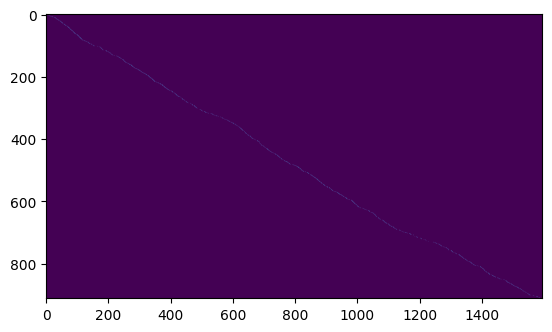

In [143]:
plt.imshow(IoUmatrix)

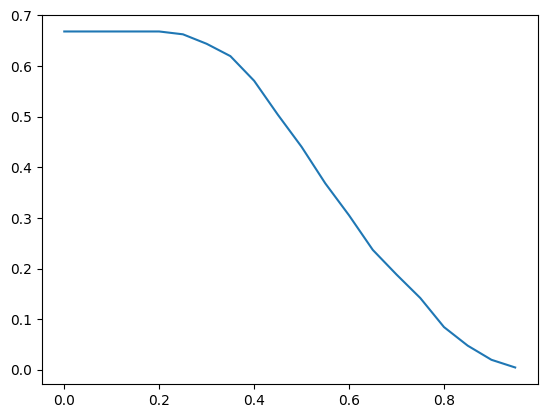

In [144]:
sampleIoUs=np.linspace(0,0.95,20)
sampleF1=[]

for thresIoU in sampleIoUs:
    sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

plt.plot(sampleIoUs,sampleF1)

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\352708932.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\352708932.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



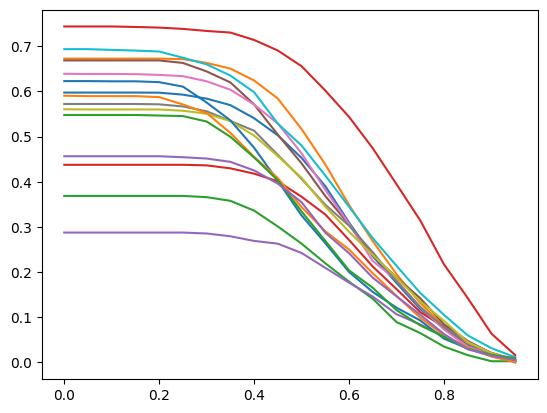

In [145]:
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)
    IoUmatrix=getIoUmatrix(annotations1,annotations2)
    
    sampleF1=[]
    for thresIoU in sampleIoUs:
        sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

    plt.plot(sampleIoUs,sampleF1)
plt.show()

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\1469183494.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\1469183494.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



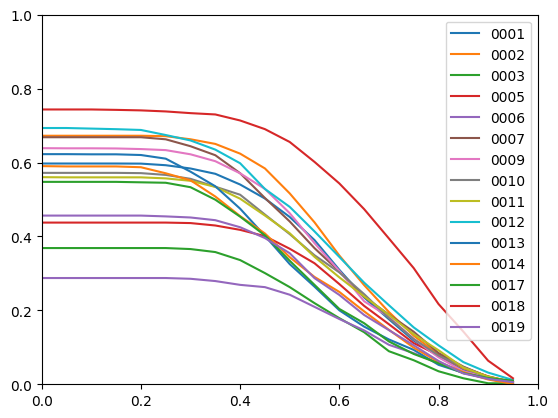

In [146]:
sampleF1_0=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)
    IoUmatrix=getIoUmatrix(annotations1,annotations2)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_0[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1
plt.plot(sampleIoUs,sampleF1_0)
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend(np.unique(annotations[annotations.labelerId=='0002'].subjectId))

Text(0, 0.5, 'F1*')

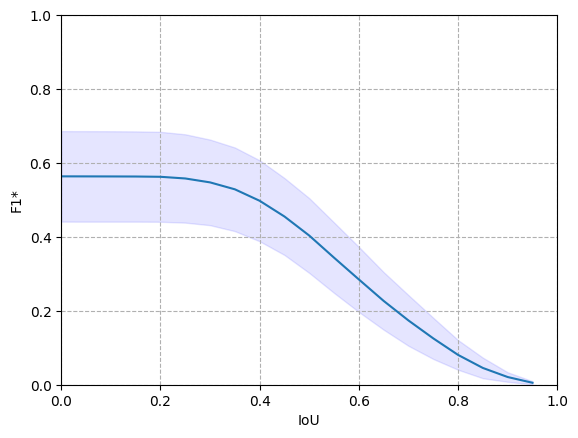

In [147]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1))
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')


## Detecting a pathological case

In [148]:
subjectId='0001'
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)

annotationPairToGraph(annotations1,annotations2,thresIoU=0)

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\3154249358.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\3154249358.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [149]:
len(annotations1)

1044

In [150]:
annotations1.iloc[874]

type               spindle
expert                  E1
subjectId             0001
labelerId             0001
startTime     25328.410141
duration          0.624962
samplerate             200
stopTime      25329.035103
startInd           5065682
stopInd            5065807
Name: 874, dtype: object

In [151]:
labels1=loadLabelsVector([subjectId],annotations1,signalsMetadata,samplerate=200)
labels2=loadLabelsVector([subjectId],annotations2,signalsMetadata,samplerate=200)

In [152]:
signals,_,_=loadMASSSpindles(masspath,returnSignals=True)
signal=signals['0001']
signal=sg.resample_poly(signal,up=25,down=32)

In [153]:
roi=[5065500,5066500]
timepoints=np.arange(0,roi[1]-roi[0])/samplerate

Text(0.5, 0, 'time / s')

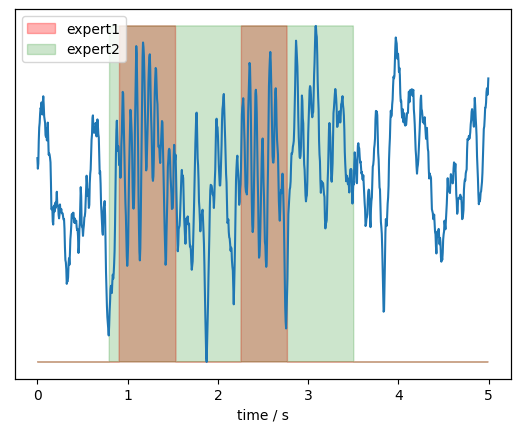

In [154]:
fig, ax1 = plt.subplots()
ax1.fill(timepoints,labels1[roi[0]:roi[1]],alpha=0.3,label='expert1',color='r')
ax1.fill(timepoints,labels2[roi[0]:roi[1]],alpha=0.2,label='expert2',color='g')
ax1.legend(loc='upper left')
ax1.set_yticks([])
ax2=ax1.twinx()
ax2.plot(timepoints,signal[roi[0]:roi[1]])
ax2.set_yticks([])
ax1.set_xlabel("time / s")

In [155]:
from plotly.subplots import make_subplots

roi=[5065500,5066500]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(y=labels1[roi[0]:roi[1]], fill='tozeroy',mode='none',name='expert1'))
fig.add_trace(go.Scatter(y=labels2[roi[0]:roi[1]]*1, fill='tozeroy',mode='none',name='expert2'))
#fig.add_trace(go.Scatter(y=testLabels[roi[0]:roi[1]], fill='tozeroy',mode='none',name='GT'))
#fig.add_trace(go.Scatter(y=signals[subjectId][roi[0]:roi[1]],name='signal'), secondary_y=True)
fig.show()

In [156]:
from plotly.subplots import make_subplots

roi=[5065500,5066500]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(y=labels1[roi[0]:roi[1]], fill='tozeroy',mode='none',name='expert1'))
fig.add_trace(go.Scatter(y=labels2[roi[0]:roi[1]]*1, fill='tozeroy',mode='none',name='expert2'))
#fig.add_trace(go.Scatter(y=testLabels[roi[0]:roi[1]], fill='tozeroy',mode='none',name='GT'))
#fig.add_trace(go.Scatter(y=signals[subjectId][roi[0]:roi[1]],name='signal'), secondary_y=True)
fig.show()

In [157]:
mini1=annotations1.iloc[874:876]
mini2=annotations2.iloc[2024:2025]

In [158]:
mini1

type expert subjectId labelerId     startTime  duration  samplerate  \
874  spindle     E1      0001      0001  25328.410141  0.624962         200   
875  spindle     E1      0001      0001  25329.761141  0.507782         200   

         stopTime  startInd  stopInd  
874  25329.035103   5065682  5065807  
875  25330.268923   5065952  5066054

In [159]:
mini2

type expert subjectId labelerId     startTime  duration  samplerate  \
2024  spindle     E2      0001      0002  25328.300322  2.702952         200   

          stopTime  startInd  stopInd  
2024  25331.003274   5065660  5066201

In [160]:
len(annotations)

33269

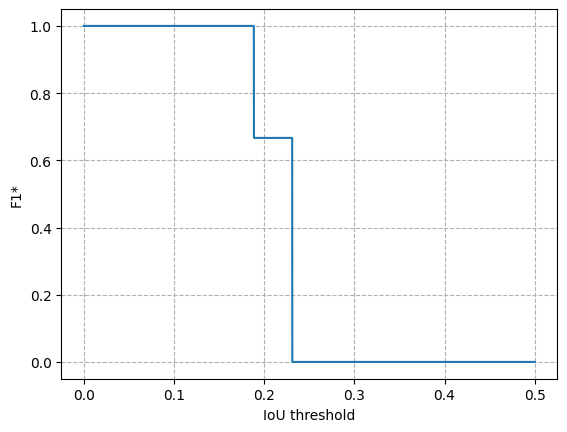

In [161]:
sampleIoUs2=np.linspace(0,0.5,10000)
sampleF1=[]

IoUmatrix=getIoUmatrix(mini1,mini2)

for thresIoU in sampleIoUs2:
    sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

plt.plot(sampleIoUs2,sampleF1,linestyle='-')
#plt.vlines(x=[0.2310536,0.1885397],ymin=0,ymax=1,linestyles='--',colors='k')
plt.xlabel("IoU threshold")
plt.ylabel("F1*")
plt.grid(linestyle='--')

another case

here the expert 2 has labeled two overlapping annotations! we can not visualise it as before

In [162]:
subjectId='0011'
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)

annotationPairToGraph(annotations1,annotations2,thresIoU=0)

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\2414542793.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\2414542793.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [163]:
len(annotations1)

606

In [164]:
annotations1.iloc[424]

type               spindle
expert                  E1
subjectId             0011
labelerId             0001
startTime      18820.45651
duration          1.109306
samplerate             200
stopTime      18821.565816
startInd           3764091
stopInd            3764313
Name: 424, dtype: object

In [165]:
annotations2.iloc[1247:1249]

type expert subjectId labelerId     startTime  duration  samplerate  \
1247  spindle     E2      0011      0002  18820.275470  1.288980         200   
1248  spindle     E2      0011      0002  18821.283218  0.320292         200   

         stopTime  startInd  stopInd  
1247  18821.56445   3764055  3764313  
1248  18821.60351   3764257  3764321

notice this two annotations of the second expert overlap

## Save all graphs from the expert comparison

In [166]:
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)

    fig=annotationPairToGraph(annotations1,annotations2,thresIoU=0)
    fig.write_html("graph_"+subjectId+".html")

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\729700063.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\GIB\

## labeler1 model predicts labeler2

In [167]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir) 

workbookDir: C:\Users\GIB\Documents\GitHub\SpinCo\SpinCo\011_MASS_features_250botstrapiterations


In [168]:
experimentModels=loadPickle(os.getcwd()+"/experimentModelsTest_ValidationperModel_Testing_N2_E1_IoU-0.3_temp.pkl")
featureSelection=loadPickle(os.getcwd()+"/featureSelection_250bootstraping_iterations.pkl")


In [169]:
experimentId="526685ff-765e-4c02-b4aa-23958be9563f"

In [170]:
experimentModels1=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)


In [171]:
#Hyper params for E1
hyperClose=0.1
hyperDuration=0.3
maxDuration=5


In [172]:
annotationsN2=pd.read_csv(datapath+'/MASS/annotations/spindlesFilteredN2.csv')
annotationsN2['samplerate']=samplerate
annotationsN2['subjectId']=annotationsN2.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
annotationsN2['labelerId']=annotationsN2.apply(
    lambda row: str(row.labelerId).zfill(4),axis=1)
annotationsN2['stopTime']=annotationsN2.apply(
    lambda row: row.startTime+row.duration , axis=1)
annotationsN2['startInd']=annotationsN2.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
annotationsN2['stopInd']=annotationsN2.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)

In [173]:
## load hypnograms
stagesAnnotations=pd.read_csv(datapath+"\MASS\stages\stages.csv")
stagesAnnotations['samplerate']=samplerate
stagesAnnotations['subjectId']=stagesAnnotations.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
stagesAnnotations['stopTime']=stagesAnnotations.apply(
    lambda row: row.startTime+row.duration , axis=1)
stagesAnnotations['startInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
stagesAnnotations['stopInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
stagesAnnotations.head(5)

hypnograms={}
for ind, row in signalsMetadata.iterrows():
    subjectId=row.subjectId
    thisStages=stagesAnnotations[stagesAnnotations.subjectId==subjectId]
    excerptDimension=int(row.duration*row.samplerate)
    thisHypnogram=np.ones((excerptDimension,))*np.nan
    for ind_stg, row_stg in thisStages.iterrows():
        thisHypnogram[row_stg.startInd:row_stg.stopInd]=row_stg.value
    hypnograms[subjectId]=thisHypnogram   

In [174]:
experimentModels1

criteriumId criteriumName labelerIdList  \
0         0001            E1        [0001]   
1         0001            E1        [0001]   
2         0001            E1        [0001]   
3         0001            E1        [0001]   
4         0001            E1        [0001]   
5         0001            E1        [0001]   
6         0001            E1        [0001]   
7         0001            E1        [0001]   
8         0001            E1        [0001]   
9         0001            E1        [0001]   
10        0001            E1        [0001]   
11        0001            E1        [0001]   
12        0001            E1        [0001]   
13        0001            E1        [0001]   
14        0001            E1        [0001]   

                                                train                 val  \
0   [0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...  [0017, 0002, 0006]   
1   [0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...  [0006, 0013, 0019]   
2   [0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...  [0013, 0006, 0001]   
3   [0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...  [0018, 0014, 0012]   
4   [0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...  [0005, 0001, 0002]   
5   [0001, 0002, 0003, 0010, 0011, 0012, 0013, 001...  [0005, 0006, 0009]   
6   [0001, 0003, 0005, 0006, 0007, 0010, 0011, 001...  [0002, 0017, 0013]   
7   [0002, 0003, 0005, 0006, 0007, 0009, 0012, 001...  [0017, 0001, 0011]   
8   [0001, 0003, 0005, 0006, 0009, 0010, 0012, 001...  [0002, 0018, 0007]   
9   [0002, 0003, 0005, 0006, 0009, 0011, 0013, 001...  [0001, 0007, 0010]   
10  [0002, 0003, 0005, 0006, 0007, 0010, 0011, 001...  [0009, 0001, 0012]   
11  [0001, 0002, 0003, 0005, 0006, 0007, 0009, 001...  [0010, 0012, 0011]   
12  [0002, 0003, 0005, 0006, 0007, 0009, 0011, 001...  [0010, 0018, 0001]   
13  [0001, 0002, 0005, 0006, 0007, 0010, 0011, 001...  [0012, 0003, 0009]   
14  [0001, 0002, 0005, 0007, 0009, 0010, 0011, 001...  [0014, 0006, 0003]   

    test                               modelId  spindleTimeRate     rawF1  \
0   0001  4ecbf9fd-9ea2-41f6-82ce-b88ac9b32b76         0.018639  0.776583   
1   0002  510c627b-7f5d-47cf-806f-77699d7869bf         0.020055  0.722956   
2   0003  81fc4ed7-34db-485d-8b93-027a1d57313e         0.021075  0.581979   
3   0005  edd43941-9867-4361-a47e-36b0c1e13e96         0.018331  0.674714   
4   0006  f76f3dc0-a712-49f3-842b-590c783bc6ca         0.019222  0.592905   
5   0007  bedbb2e2-c55d-4931-8937-6ff81b1df99a         0.019625  0.678334   
6   0009  d795bc85-43d1-4349-bf03-fe100d40daf9         0.017824  0.755161   
7   0010  02e88dcd-63b9-408e-848d-a849fc2567a1         0.017542  0.765355   
8   0011  a090862a-9778-4431-9c22-e5d33b1a116c         0.015442  0.688069   
9   0012  e7e4df1d-6250-40e8-bf6c-79a6ed4dbdab         0.016460  0.695093   
10  0013  d47997e9-0f93-4c68-8bfe-3d64bd24b612         0.017297  0.681980   
11  0014  eb8f4601-7957-4990-ba3b-c6892c7180c2         0.017868  0.644886   
12  0017  068a1a2c-d011-489a-be3e-8c36cceb0721         0.016504  0.704239   
13  0018  32691b47-eae8-4fd8-906e-315585ba2df6         0.018626  0.687454   
14  0019  4b322b8b-1809-4f6e-ac12-994435d2fc30         0.022439  0.635450   

    rawPrecision  rawRecall        f1  precision    recall   eventF1  \
0       0.820991   0.736732  0.777941   0.820994  0.739179  0.844776   
1       0.810349   0.652579  0.723949   0.815995  0.650565  0.788799   
2       0.435384   0.877406  0.593606   0.449112  0.875177  0.631829   
3       0.652232   0.698802  0.683151   0.674556  0.691969  0.746186   
4       0.828697   0.461572  0.582808   0.838082  0.446735  0.650206   
5       0.631092   0.733221  0.681970   0.634807  0.736703  0.747076   
6       0.811974   0.705779  0.761826   0.819650  0.711623  0.838433   
7       0.802887   0.731175  0.768911   0.810166  0.731653  0.849624   
8       0.569248   0.869581  0.692297   0.574346  0.871215  0.728143   
9       0.829438   0.598202  0.695093   0.835747  0.594963  0.780908   
10      

In [175]:
sampleF1_1=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for ind,row in experimentModels1.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels1)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    
    #Define annotations criterium   *********************************************
    usedAnnotations=annotationsN2[annotationsN2.labelerId=='0002'].reset_index(drop=True)
    #***************************************************************************

    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict

    hyperThres=row.Binarization_Threshold
    hyperDepth=int(row.Boosting_Iterations)
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    
    #**********************************************
    processedAnnotations=processedAnnotations[processedAnnotations.duration<maxDuration]
    #**********************************************

    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    
    IoUmatrix=getIoUmatrix(gtAnnotations,processedAnnotations)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_1[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1    
    

*************************
1 of 15
*************************
2 of 15
*************************
3 of 15
*************************
4 of 15
*************************
5 of 15
*************************
6 of 15
*************************
7 of 15
*************************
8 of 15
*************************
9 of 15
*************************
10 of 15
*************************
11 of 15
*************************
12 of 15
*************************
13 of 15
*************************
14 of 15
*************************
15 of 15


## labeler2 model predicts labeler1

In [176]:
#Hyper params for E2
hyperClose=0.1
hyperDuration=0.3
maxDuration=5

In [177]:
experimentModels=loadPickle(os.getcwd()+"/experimentModelsTest_ValidationperModel_Testing_N2_E2_IoU-0.3_temp.pkl")
featureSelection=loadPickle(os.getcwd()+"/featureSelection_250bootstraping_iterations.pkl")

In [178]:
experimentModels2=experimentModels[experimentModels.criteriumName=='E2'].reset_index(drop=True)
experimentModels2

criteriumId criteriumName labelerIdList  \
0         0002            E2        [0002]   
1         0002            E2        [0002]   
2         0002            E2        [0002]   
3         0002            E2        [0002]   
4         0002            E2        [0002]   
5         0002            E2        [0002]   
6         0002            E2        [0002]   
7         0002            E2        [0002]   
8         0002            E2        [0002]   
9         0002            E2        [0002]   
10        0002            E2        [0002]   
11        0002            E2        [0002]   
12        0002            E2        [0002]   
13        0002            E2        [0002]   
14        0002            E2        [0002]   

                                                train                 val  \
0   [0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...  [0017, 0002, 0006]   
1   [0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...  [0006, 0013, 0019]   
2   [0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...  [0013, 0006, 0001]   
3   [0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...  [0018, 0014, 0012]   
4   [0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...  [0005, 0001, 0002]   
5   [0001, 0002, 0003, 0010, 0011, 0012, 0013, 001...  [0005, 0006, 0009]   
6   [0001, 0003, 0005, 0006, 0007, 0010, 0011, 001...  [0002, 0017, 0013]   
7   [0002, 0003, 0005, 0006, 0007, 0009, 0012, 001...  [0017, 0001, 0011]   
8   [0001, 0003, 0005, 0006, 0009, 0010, 0012, 001...  [0002, 0018, 0007]   
9   [0002, 0003, 0005, 0006, 0009, 0011, 0013, 001...  [0001, 0007, 0010]   
10  [0002, 0003, 0005, 0006, 0007, 0010, 0011, 001...  [0009, 0001, 0012]   
11  [0001, 0002, 0003, 0005, 0006, 0007, 0009, 001...  [0010, 0012, 0011]   
12  [0002, 0003, 0005, 0006, 0007, 0009, 0011, 001...  [0010, 0018, 0001]   
13  [0001, 0002, 0005, 0006, 0007, 0010, 0011, 001...  [0012, 0003, 0009]   
14  [0001, 0002, 0005, 0007, 0009, 0010, 0011, 001...  [0014, 0006, 0003]   

    test                               modelId  spindleTimeRate     rawF1  \
0   0001  d79e5be1-85d3-472a-a22e-6481f5b1127b         0.056746  0.799741   
1   0002  604deeeb-1744-4dd9-97c3-bda02d1d0d27         0.061232  0.794033   
2   0003  fd829af9-4256-476c-bc47-c5390cafe144         0.063062  0.688000   
3   0005  9fc96fec-cfb6-405e-8f65-e083b96b4243         0.061716  0.724810   
4   0006  e2547620-adc4-4bd4-9296-83d8386b6430         0.058705  0.604715   
5   0007  04b442ab-22b5-48a7-a1c0-072c20a626f0         0.061530  0.753726   
6   0009  0d3a86ae-0c6c-4b2b-a26b-fad23892331c         0.055908  0.763482   
7   0010  caf69e05-ecee-4093-b879-c3f91599d0af         0.052347  0.786522   
8   0011  ed3f6f59-4859-4d08-b747-68d09e29b921         0.054834  0.762891   
9   0012  a3abdc6c-1e79-45d2-90a9-06416c8ffa59         0.053001  0.740945   
10  0013  7004596b-b1ca-4324-8901-a0778774435f         0.055095  0.726709   
11  0014  b53310fe-00ec-479d-9bfa-8f290e751d12         0.055557  0.706506   
12  0017  578d1542-3fb4-47a1-9d2b-58dd25c765ac         0.053827  0.682685   
13  0018  31ed4519-9d74-4339-ac68-efa3f02eff43         0.064234  0.730914   
14  0019  d47ade15-c1f2-4a60-a813-dfa7c35c1cdf         0.067005  0.693359   

    rawPrecision  rawRecall        f1  precision    recall   eventF1  \
0       0.804162   0.795369  0.800492   0.800081  0.800904  0.867677   
1       0.746058   0.848602  0.795650   0.737350  0.863960  0.871314   
2       0.543435   0.937357  0.689431   0.542872  0.944386  0.760563   
3       0.799464   0.662908  0.723515   0.803489  0.658021  0.790741   
4       0.799405   0.486284  0.607188   0.792408  0.492151  0.673267   
5       0.674947   0.853324  0.751702   0.666538  0.861816  0.803117   
6       0.816013   0.717305  0.766027   0.814220  0.723220  0.838972   
7       0.827292   0.749581  0.790258   0.823382  0.759696  0.883897   
8       0.753214   0.772820  0.764459   0.745357  0.784566  0.835443   
9       0.701112   0.785578  0.744515   0.694776  0.801925  0.821589   
10      

In [179]:
sampleF1_2=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for ind,row in experimentModels2.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels2)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    
    #Define annotations criterium   *********************************************
    usedAnnotations=annotationsN2[annotationsN2.labelerId=='0001'].reset_index(drop=True)
    #***************************************************************************

    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)
    
    hyperThres=row.Binarization_Threshold
    hyperDepth=int(row.Boosting_Iterations)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    
    #**********************************************
    processedAnnotations=processedAnnotations[processedAnnotations.duration<maxDuration]
    #**********************************************
    
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    
    IoUmatrix=getIoUmatrix(gtAnnotations,processedAnnotations)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_2[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1    

*************************
1 of 15
*************************
2 of 15
*************************
3 of 15
*************************
4 of 15
*************************
5 of 15
*************************
6 of 15
*************************
7 of 15
*************************
8 of 15
*************************
9 of 15
*************************
10 of 15
*************************
11 of 15
*************************
12 of 15
*************************
13 of 15
*************************
14 of 15
*************************
15 of 15


## Interpredictability test

In [180]:
sampleIoUs

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

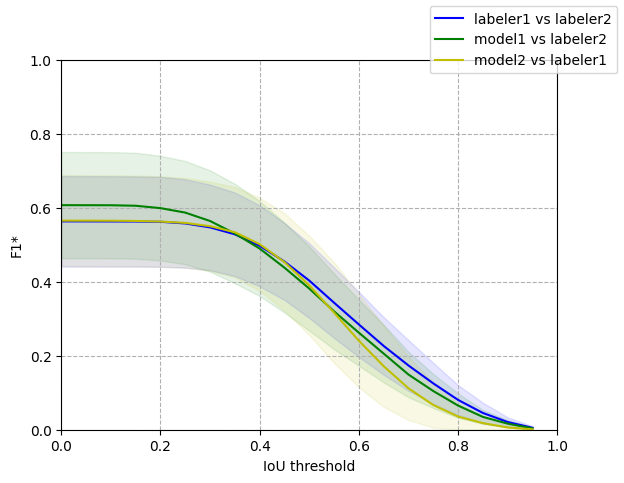

In [181]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','model1 vs labeler2','model2 vs labeler1'])

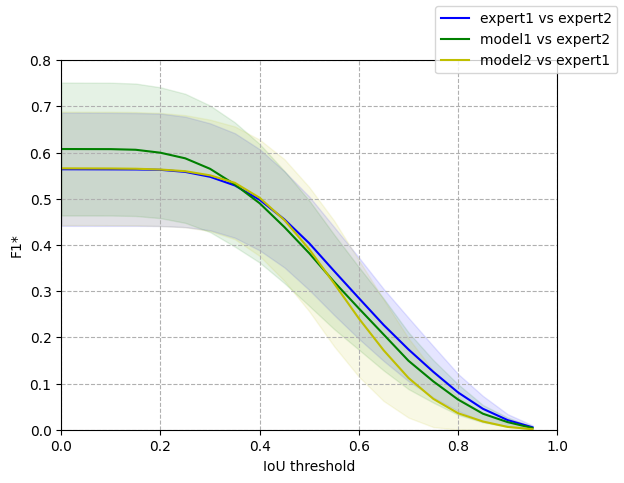

In [193]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model1 vs expert2','model2 vs expert1'])

In [194]:
fig.savefig('Fig_inter-expert_agreement.png', bbox_inches='tight', dpi=300,
            format="png")  # , pil_kwargs={"compression": "tiff_lzw"}


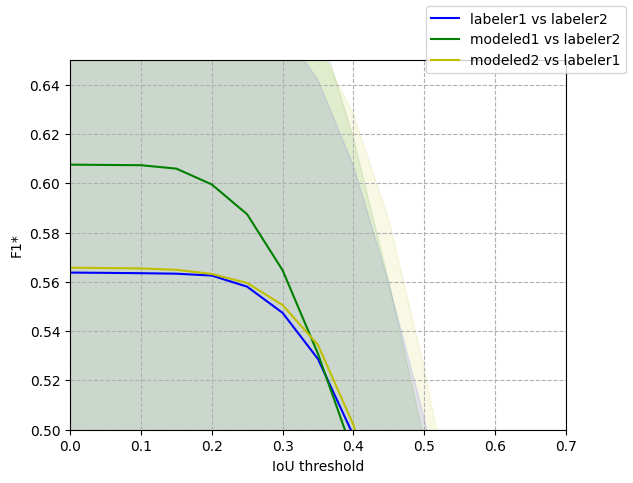

In [183]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 0.7])
ax.set_ylim([0.5, 0.65])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])

In [184]:
experimentModels2.test[0]

'0001'

C:\Users\GIB\AppData\Local\Temp\ipykernel_3596\4081508898.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



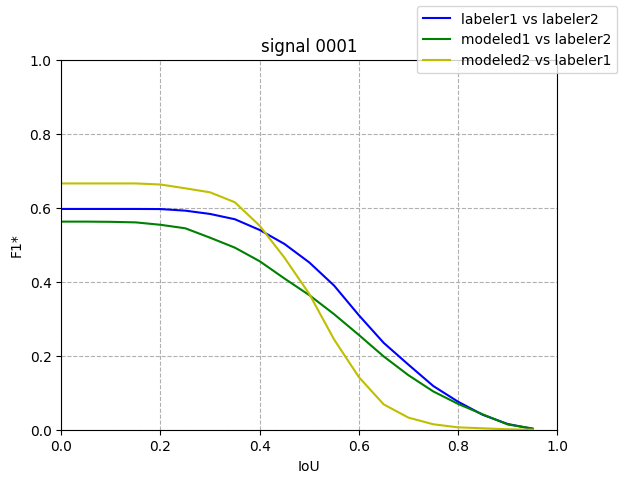

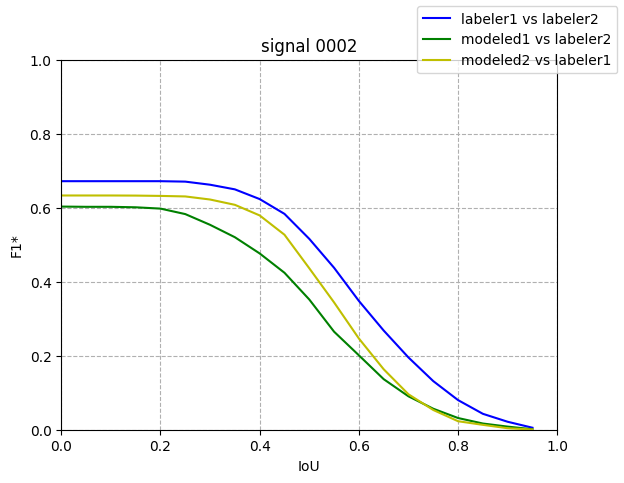

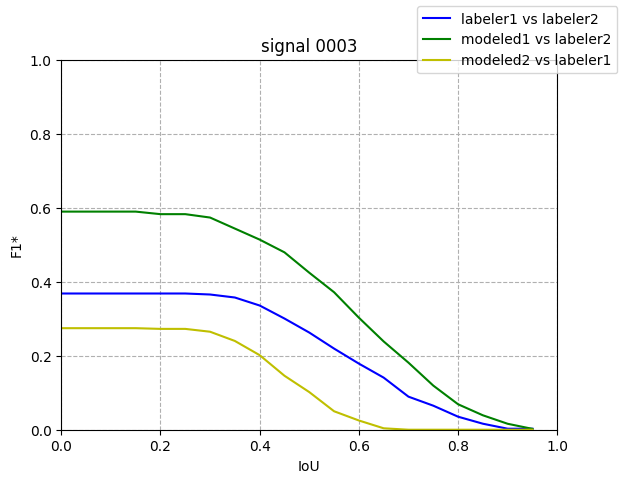

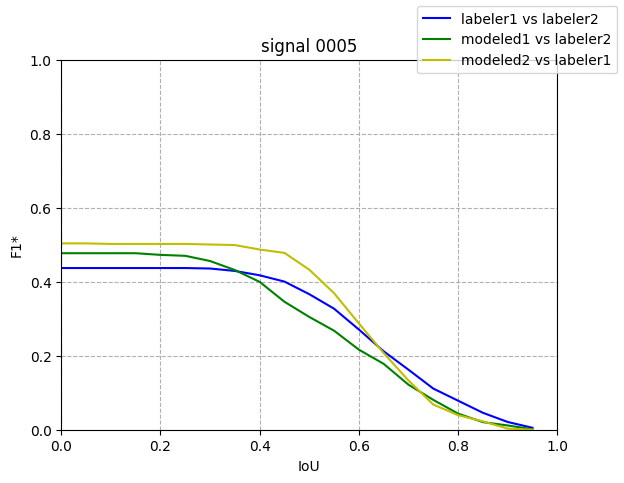

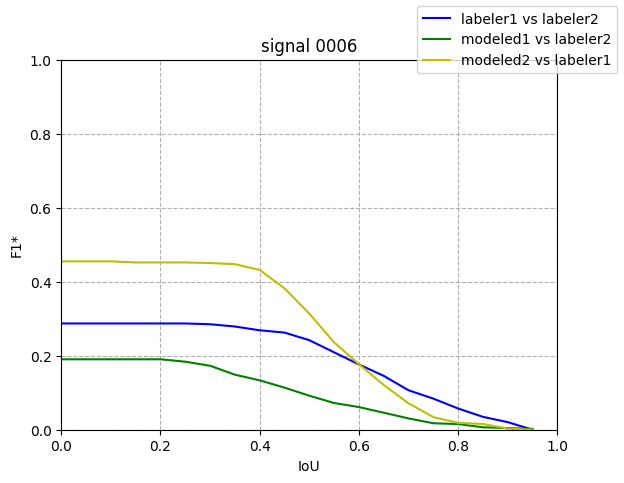

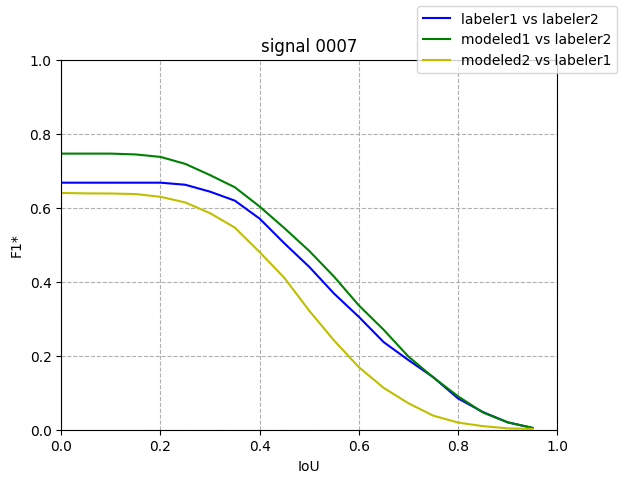

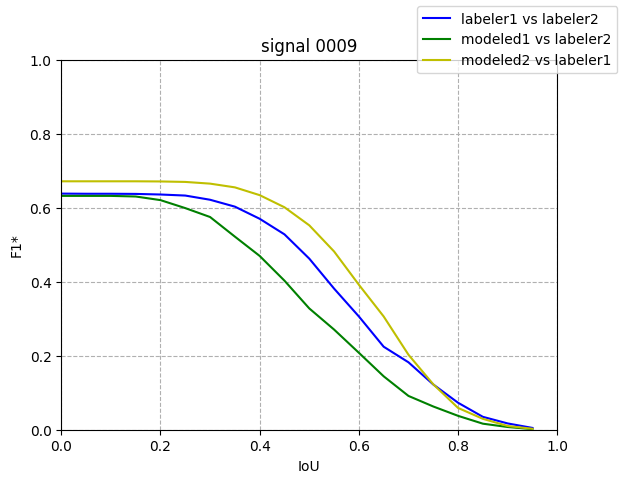

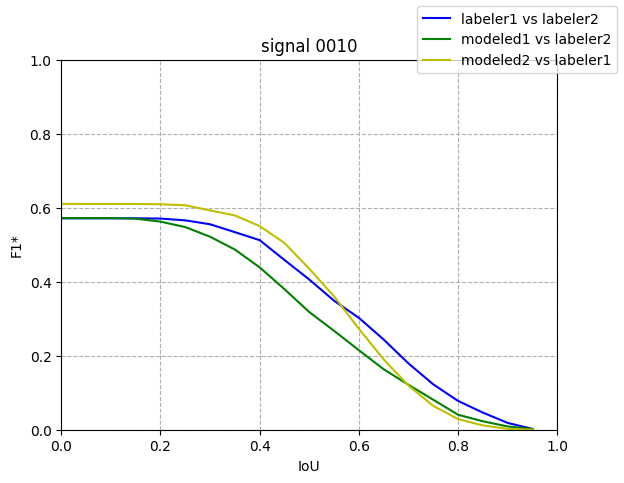

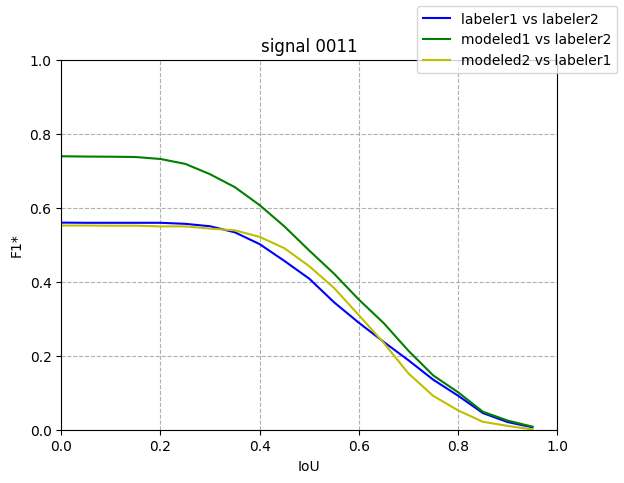

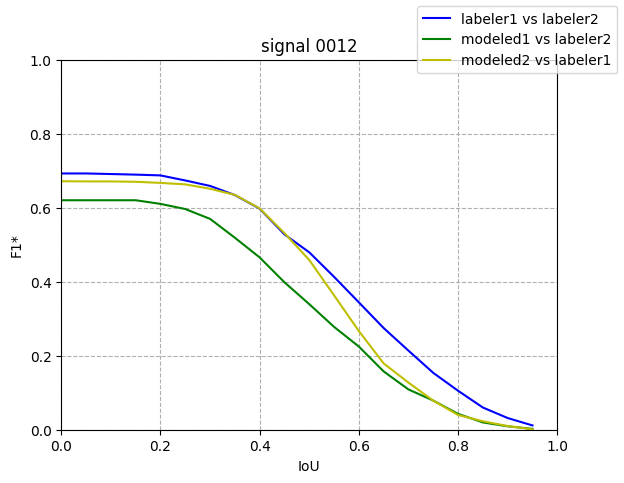

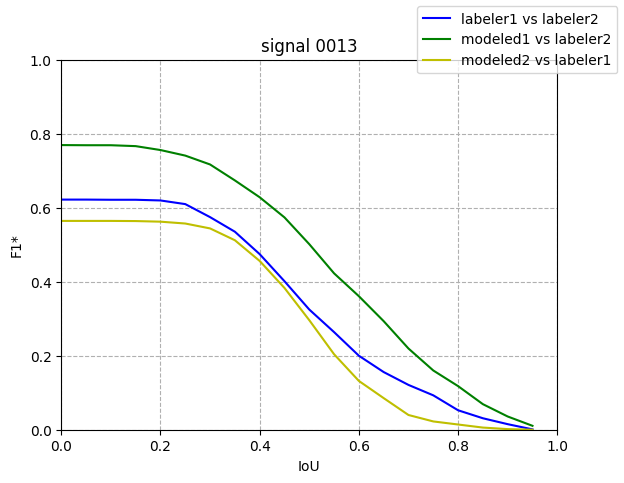

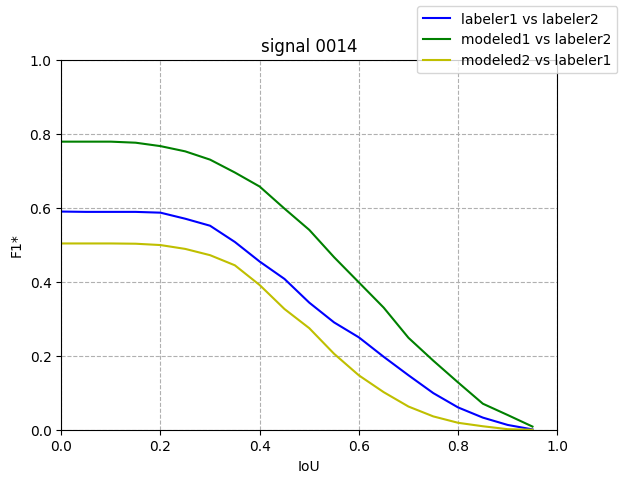

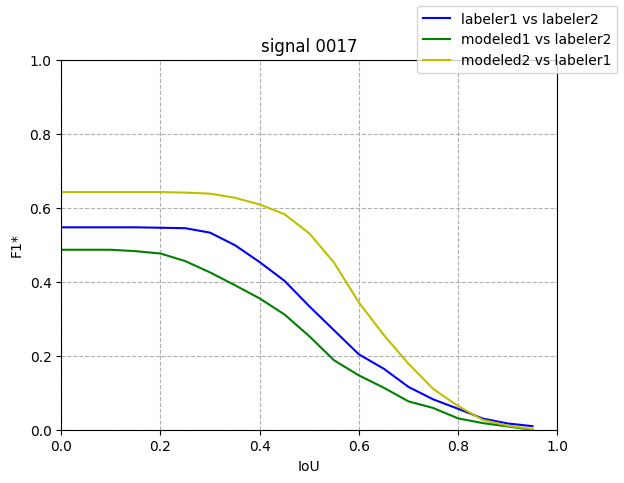

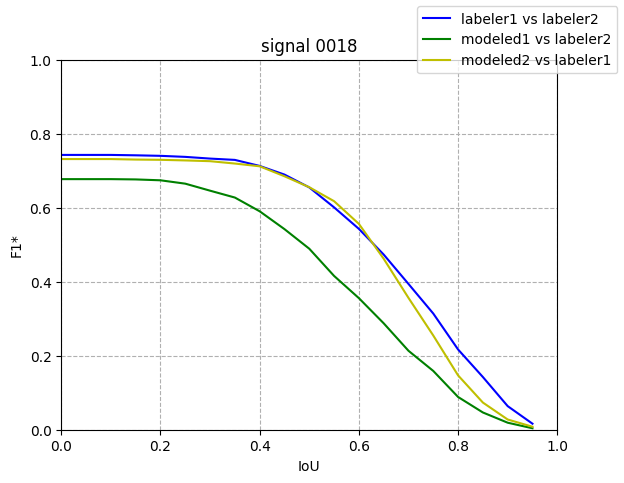

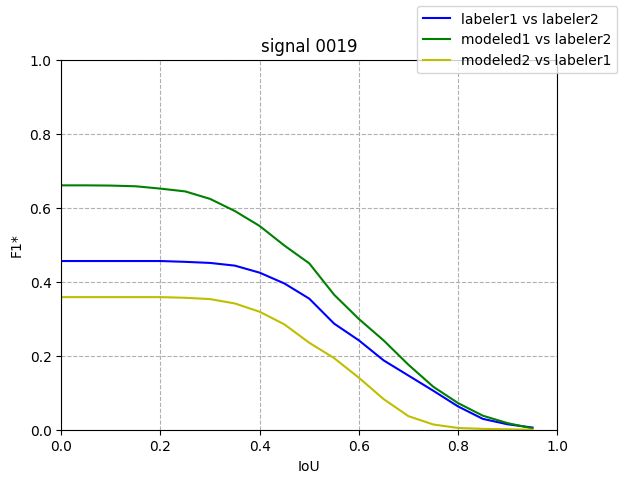

In [185]:
for i in range(sampleF1_0.shape[1]):
    fig, ax = plt.subplots()
    ax.grid(linestyle='--')
    ax.plot(sampleIoUs,sampleF1_0[:,i].flatten(),color='b')
    ax.plot(sampleIoUs,sampleF1_1[:,i],color='g')
    ax.plot(sampleIoUs,sampleF1_2[:,i],color='y')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('IoU')
    ax.set_ylabel('F1*')
    fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])
    plt.title('signal '+experimentModels2.test[i])
    fig.show()

In [186]:
sampleF1_3=(sampleF1_1+sampleF1_2)/2

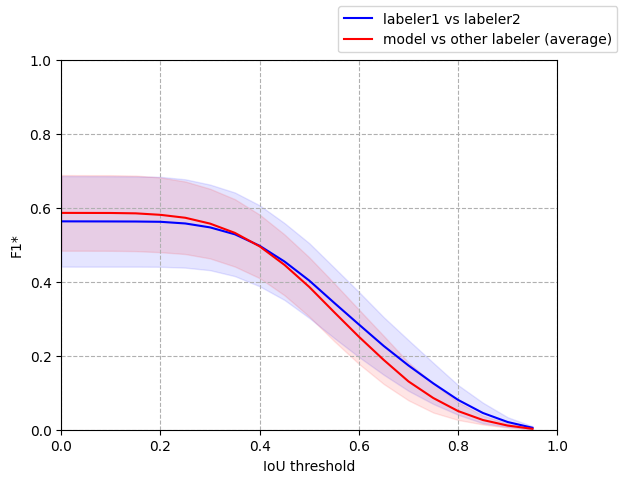

In [191]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,1])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','model vs other labeler (average)'])



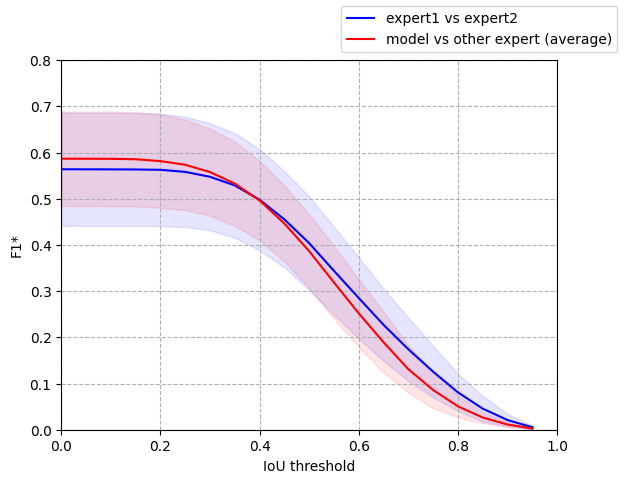

In [196]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model vs other expert (average)'])

In [197]:
fig.savefig('Fig_inter-expert_agreement_average.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

## Statistical tests

### 1. ttest

In [102]:
sampleF1_0.shape

(20, 15)

In [103]:
sampleF1_3.shape

(20, 15)

In [104]:
from scipy.stats import ttest_rel
pvalues_1=[]
for i in range(20):
    ttest_res=ttest_rel(sampleF1_0[i,:],sampleF1_1[i,:])
    pvalues_1.append(ttest_res.pvalue)

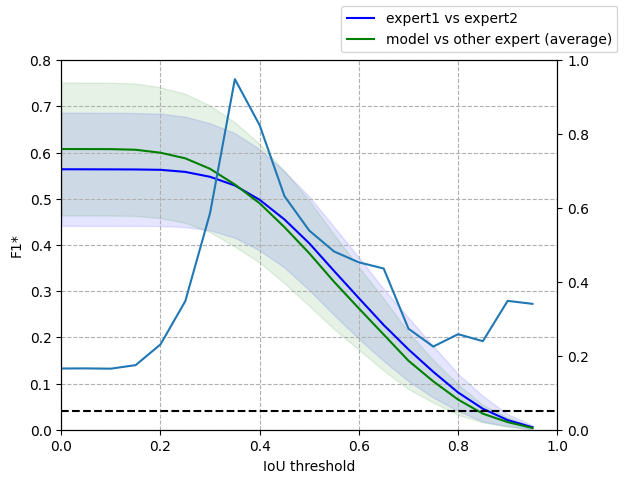

In [105]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model vs other expert (average)'])
ax2=ax.twinx()
ax2.set_ylim([0,1])

ax2.plot(sampleIoUs,pvalues_1)
ax2.hlines(0.05,0,1,linestyles='--',colors='k')

In [106]:
pvalues_2=[]
for i in range(20):
    ttest_res=ttest_rel(sampleF1_0[i,:],sampleF1_2[i,:])
    pvalues_2.append(ttest_res.pvalue)

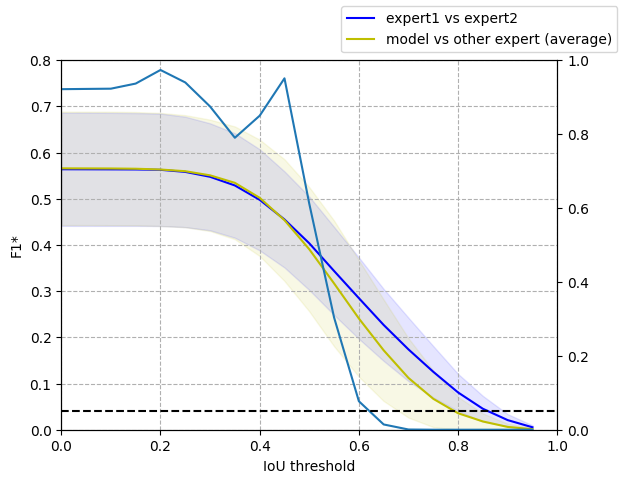

In [107]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model vs other expert (average)'])
ax2=ax.twinx()
ax2.set_ylim([0,1])

ax2.plot(sampleIoUs,pvalues_2)
ax2.hlines(0.05,0,1,linestyles='--',colors='k')

In [108]:
pvalues_3=[]
for i in range(20):
    ttest_res=ttest_rel(sampleF1_0[i,:],sampleF1_3[i,:])
    pvalues_3.append(ttest_res.pvalue)

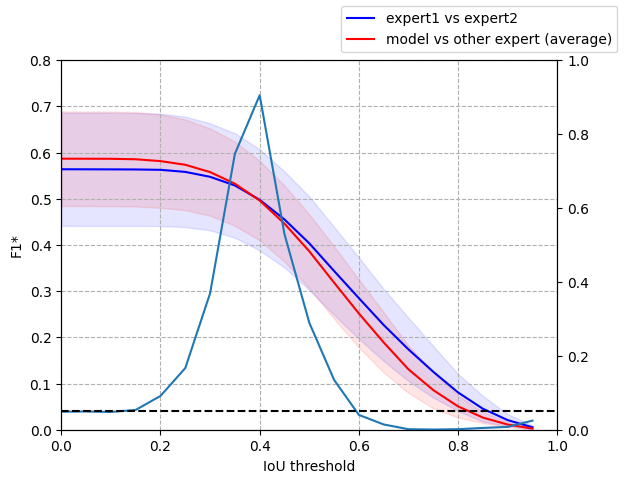

In [109]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model vs other expert (average)'])
ax2=ax.twinx()
ax2.set_ylim([0,1])

ax2.plot(sampleIoUs,pvalues_3)
ax2.hlines(0.05,0,1,linestyles='--',colors='k')

testing a different visualization

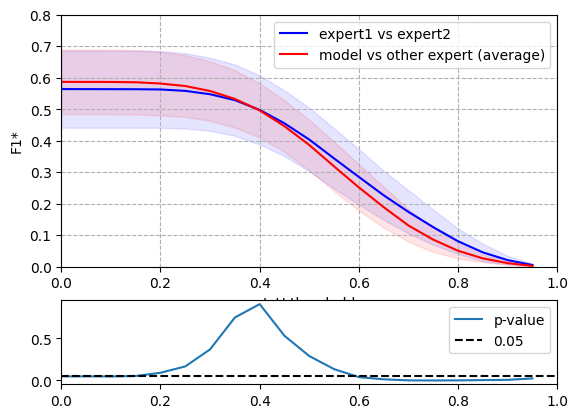

In [110]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_xlabel('IoU threshold')
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model vs other expert (average)'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues_3)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value','0.05'])


### 2. Gaussianity and homeostacity test

In [111]:
from scipy.stats import shapiro, levene

pvalues2_1=[]
for i in range(20):
    ttest_res=shapiro(sampleF1_0[i,:])
    pvalues2_1.append(ttest_res.pvalue)

In [112]:
pvalues2_1

[0.3652183413505554,
 0.36974814534187317,
 0.365202397108078,
 0.3524821400642395,
 0.3531157076358795,
 0.36842477321624756,
 0.5118999481201172,
 0.9250972867012024,
 0.9985551834106445,
 0.7697328329086304,
 0.6685991287231445,
 0.2260752022266388,
 0.022753478959202766,
 0.002773427637293935,
 0.0019595404155552387,
 0.0002677661250345409,
 0.00020389872952364385,
 4.7867742978269234e-05,
 0.00021876816754229367,
 0.08310931921005249]

In [113]:
pvalues3_1=[]
for i in range(20):
    ttest_res=levene(sampleF1_0[i,:],sampleF1_1[i,:])
    pvalues3_1.append(ttest_res.pvalue)

In [114]:
pvalues3_1

[0.826569658320554,
 0.8272324260329529,
 0.8249159293910664,
 0.8269967245168397,
 0.83787067793306,
 0.8366637426252361,
 0.769737444005917,
 0.7361055123957236,
 0.7608826321850561,
 0.6217430309924789,
 0.5982644846995954,
 0.5758486872972599,
 0.5434444982703788,
 0.3972262042850472,
 0.524785094896767,
 0.5948300211168658,
 0.5635740966047107,
 0.8524517952805222,
 0.849760980700651,
 0.39968365480380885]

### 3.non-parametric test wilcoxon

In [115]:
from scipy.stats import wilcoxon

pvalues4_1=[]
for i in range(20):
    ttest_res=wilcoxon(sampleF1_0[i,:],sampleF1_1[i,:])
    pvalues4_1.append(ttest_res.pvalue)

In [116]:
pvalues4_1

[0.30279541015625,
 0.30279541015625,
 0.30279541015625,
 0.33026123046875,
 0.45428466796875,
 0.52447509765625,
 0.638671875,
 0.76153564453125,
 1.0,
 0.803955078125,
 0.638671875,
 0.45428466796875,
 0.5994873046875,
 0.48870849609375,
 0.27685546875,
 0.22930908203125,
 0.30279541015625,
 0.30279541015625,
 0.389404296875,
 0.30279541015625]

Text(0, 0.5, 'p-value')

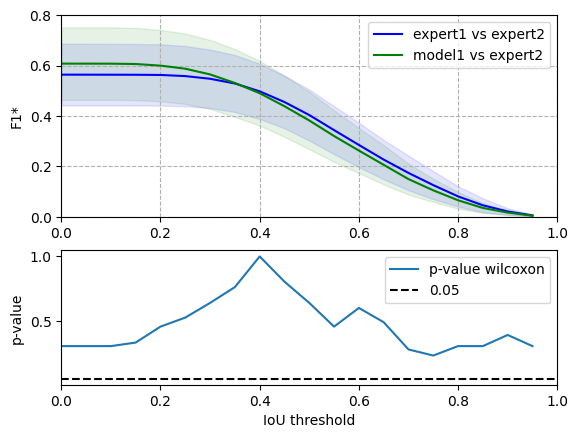

In [117]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 2]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model1 vs expert2'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues4_1)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value wilcoxon','0.05'])
ax[1].set_xlabel('IoU threshold')
ax[1].set_ylabel('p-value')




In [118]:
pvalues4_2=[]
for i in range(20):
    ttest_res=wilcoxon(sampleF1_0[i,:],sampleF1_2[i,:])
    pvalues4_2.append(ttest_res.pvalue)

C:\Users\GIB\Documents\GitHub\SpinCo\venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



In [119]:
pvalues4_2

[0.97796630859375,
 0.97796630859375,
 0.97796630859375,
 0.93408203125,
 0.890380859375,
 0.890380859375,
 1.0,
 0.890380859375,
 0.890380859375,
 0.846923828125,
 0.5994873046875,
 0.30279541015625,
 0.10699462890625,
 0.00836181640625,
 0.00152587890625,
 0.00030517578125,
 0.0001220703125,
 6.103515625e-05,
 6.103515625e-05,
 0.0009815397525216685]

Text(0, 0.5, 'p-value')

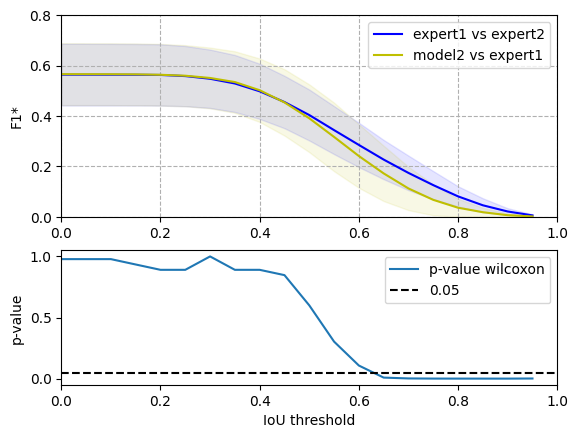

In [120]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 2]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model2 vs expert1'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues4_2)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value wilcoxon','0.05'])
ax[1].set_xlabel('IoU threshold')
ax[1].set_ylabel('p-value')


In [121]:
pvalues4_3=[]
for i in range(20):
    ttest_res=wilcoxon(sampleF1_0[i,:],sampleF1_3[i,:])
    pvalues4_3.append(ttest_res.pvalue)

In [122]:
pvalues4_3

[0.083251953125,
 0.083251953125,
 0.083251953125,
 0.083251953125,
 0.0946044921875,
 0.10699462890625,
 0.45428466796875,
 0.5614013671875,
 0.97796630859375,
 0.48870849609375,
 0.30279541015625,
 0.1688232421875,
 0.05535888671875,
 0.0301513671875,
 0.00537109375,
 0.0008544921875,
 0.00115966796875,
 0.0008544921875,
 0.0042724609375,
 0.02557373046875]

Text(0, 0.5, 'p-value')

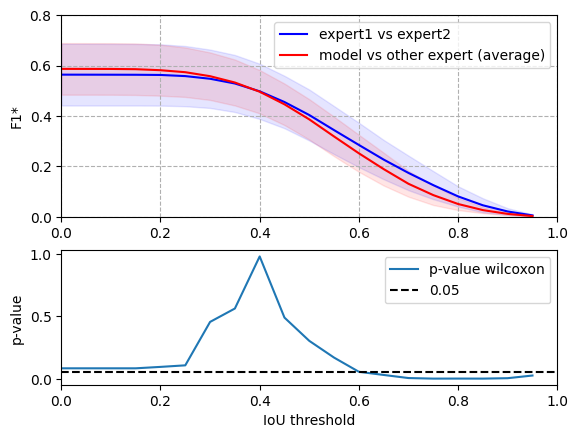

In [123]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 2]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model vs other expert (average)'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues4_3)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value wilcoxon','0.05'])
ax[1].set_xlabel('IoU threshold')
ax[1].set_ylabel('p-value')



### 4. Non-parametric test Mann-Whitney

In [124]:
from scipy.stats import mannwhitneyu

pvalues5_1=[]
for i in range(20):
    ttest_res=mannwhitneyu(sampleF1_0[i,:],sampleF1_1[i,:])
    pvalues5_1.append(ttest_res.pvalue)

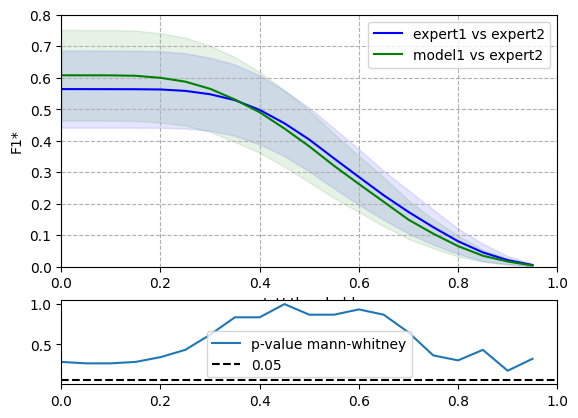

In [125]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_xlabel('IoU threshold')
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model1 vs expert2'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues5_1)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value mann-whitney','0.05'])


In [126]:
pvalues5_2=[]
for i in range(20):
    ttest_res=mannwhitneyu(sampleF1_0[i,:],sampleF1_2[i,:])
    pvalues5_2.append(ttest_res.pvalue)

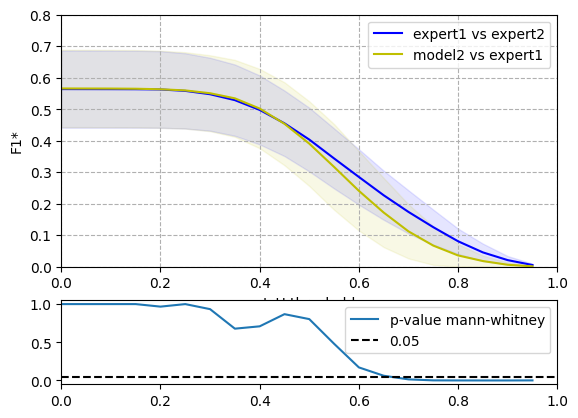

In [127]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_xlabel('IoU threshold')
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model2 vs expert1'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues5_2)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value mann-whitney','0.05'])


In [128]:
pvalues5_3=[]
for i in range(20):
    ttest_res=wilcoxon(sampleF1_0[i,:],sampleF1_3[i,:])
    pvalues5_3.append(ttest_res.pvalue)

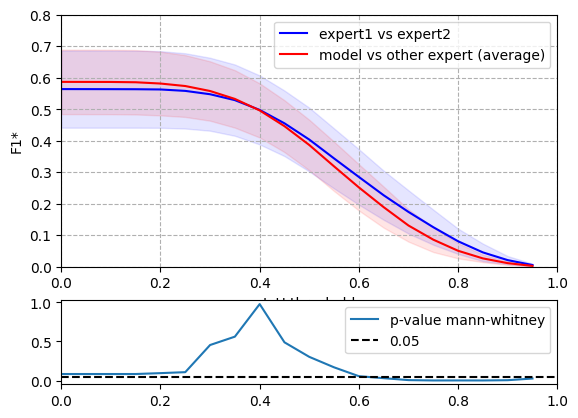

In [129]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
ax[0].grid(linestyle='--')
ax[0].plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax[0].plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax[0].fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0,0.8])
ax[0].set_xlabel('IoU threshold')
ax[0].set_ylabel('F1*')
ax[0].legend(['expert1 vs expert2','model vs other expert (average)'])

ax[1].set_xlim([0,1])
ax[1].plot(sampleIoUs,pvalues5_3)
ax[1].hlines(0.05,0,1,linestyles='--',colors='k')
ax[1].legend(['p-value mann-whitney','0.05'])
